In [1]:
# If you are reading this notebook on a Binder, make sure to right-click the file name in
# the left-side file viewer and select `Open With > Notebook` to view this as a notebook

# <i class="fas fa-book fa-fw"></i> Decision Trees

In this chapter, we will introduce a popular type of model called a **Decision Tree**. Decision trees are based on the intuitive decision-making tool humans often use called a flow chart. For example, here is the University of Washington's flowchart that they share with students, staff, and faculty to help them determine which actions to take when they contract or are exposed to COVID. A flowchart (or decision tree) asks as sequence of questions, and you follow the path depending on how you answer the questions. Ultimately the path leads to a node that gives you a decision that you can act on.

```{figure} uw_covid.png
---
alt: A flowchart describing what to do when exposed to COVID or test positive
width: 100%
align: center
---
University of Washington's Public Health Flowchart for COVID-19 Pandemic (2023)
```

## Parametric vs Non-parametric Methods

So as we've mentioned before, we will be learning a plethora of different models in the remainder of this book. As we suggested, it helps to compare/contrast models to better understand their properties and why you may want to use one over the other.

One way to group models into what assumptions they make about the world and how they are formulated. One distinction that is commonly made is between **parameteric models** and **non-parametric models**.

**Parametric models** are ones that make an assumption about the distribution of the data and require learning some finite number of parameters. Linear regression, Logistic Regression, and Naïve Bayes are all examples of parametric models. Linear regression, for example, assumes there is a linear relationship between the inputs and outputs, and there is some normally-distributed noise around the the linear function. To learn the model, we learn a number of parameters $\hat{w} \in \mathbb{R}^D$ for our $D$-dimensional features $h(x)$. A useful approximation for parametric models are ones where you can write down the predictions as a tidy formula such as $\hat{y} = \hat{w}^Th(x)$.

On the other hand **non-parametric models** are ones that (mostly) don't make strong assumptions about the data distribution, and/or aren't represented by a fixed number of parameters. This is often described as models that can scale in complexity based on how much training data is available. In the rest of this chapter, we will discuss our first non-parametric model with Decision Trees.


## Loan Safety

For this chapter and the next, we will be switching our example scenario from predicting sentiment of a review, to predicting whether or not it is safe to give a loan to a potential applicant. In terms of a modelling task, we will gather information from the applicant about their credit history, their income, how long of a term they are looking for the loan, and other information about them. We will use that information as inputs for our model to lead to predictions of Safe (+1) or Risky (-1). Below, we show an (made up) example dataset for this task.

```{table} Example Loan Safety Dataset
:name: loan_safety

| Credit    | Term  | Income | Label  |
|-----------|-------|--------|--------|
| excellent | 3 yrs | high   | safe   |
| fair      | 5 yrs | low    | risky  |
| fair      | 3 yrs | high   | safe   |
| poor      | 5 yrs | high   | risky  |
| excellent | 3 yrs | low    | safe   |
| fair      | 5 yrs | low    | safe   |
| poor      | 3 yrs | high   | risky  |
| poor      | 6 yrs | low    | safe   |
| fair      | 3 yrs | high   | safe   |
```

Before discussing the ML algorithm we will discuss and how we make predictions, it's important to make sure we are asking questions about what we are modeling and why. Consider our discussions from the last chapter on {doc}`../bias_fairness/index`. What concerns might we have about potential biases in our data or fairness concerns we should consider for our predictions? We asked our students this question, and they outlined just a couple of many concerns or questions we should explore in depth before deploying such a model.

* What are the effects of the errors are model will make? Should we be concerned about disparate cost between a false-positive and false-negative? Can there be a compounding effect of using our model that might lead to a financial crisis like the one we went through in 2008? How do we audit our model to ensure it doesn't cause those effects?
* There are likely biases present in our training data, which will cause biased outcomes of our predictions. Just for example, there are many economic factors that we think about affecting loan safety that may disproportionately make a group less qualified when they are actually just as loan-worthy. For example, black Americans have suffered from disproportionate economic hardships due to factors such as redlining, inequitable access to high-paying jobs, and any other reason we can imagine structural bias affecting information about loan safety.
* What legal constraints does are model need to abide by? Is there a requirement on how fairness should be defined? Even if there aren't legal requirements, which fairness values to we care to uphold in our model?

We won't provide answers to these questions in this chapter, not because they aren't important, but because they are fundamentally outside the realm of algorithmic solutions. Just like in {doc}`../bias_fairness/index`, these are questions that need to be answered, but require human discussion and input for what social values we want to encode in our model and why. In this chapter, we will largely skip over these questions to focus on the core concepts of the modeling task. Everything we discuss in this chapter can be augmented with the fairness concepts we discussed earlier.

## Decision Trees

At a high level, a **Decision Tree** is a flowchart about our data to make predictions about the labels. We ask questions, going left or right down the tree based on the answers, to come to a prediction. The nodes in the middle of the tree are called **branch nodes** or **internal nodes** that ask questions about the input data while the decisions (Safe/Risky) are stored in the **leaf nodes** at the bottom. You might find that terminology a bit backwards, but you can imagine it as an upside-down tree where the root is at the top and the leaves are at the bottom.

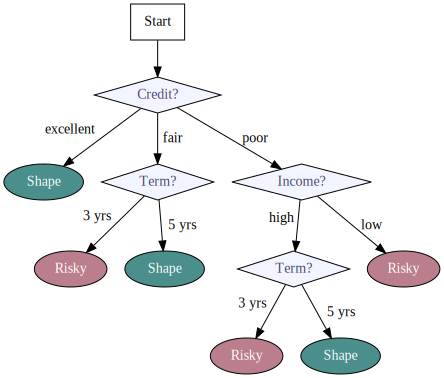

In [2]:
# TODO This doesn't work well for most of our diagrams so I'm hiding it entirely. Would love to come back and make these
# look nice.

from graphviz import Digraph

BRANCH_STYLE = {"shape": "diamond", "fillcolor": "#F2F4FF", "fontcolor": "#474973", "style": "filled"}
SAFE_STYLE = {"label": "Shape", "shape": "oval", "fillcolor": "#4B8F8C", "fontcolor": "#FFFFFF", "style": "filled"}
RISKY_STYLE = {"label": "Risky", "shape": "oval", "fillcolor": "#BB7E8C", "fontcolor": "#FFFFFF", "style": "filled"}

SAFE_FONT = "#6E8031"
RISKY_FONT = "#963334"

def font_color(text, color):
  return f'<FONT COLOR="{color}">{text}</FONT>'

# Create Digraph object
dot = Digraph()

# Make nodes and edges
dot.node("Start", shape="box")

dot.node("Credit?",  **BRANCH_STYLE)
dot.node("safe1", **SAFE_STYLE)
dot.node("term1", label="Term?",  **BRANCH_STYLE)
dot.node("Income?",  **BRANCH_STYLE)
dot.edge("Start", "Credit?")
dot.edge("Credit?", "safe1", xlabel="excellent")
dot.edge("Credit?", "term1", label=" fair")
dot.edge("Credit?", "Income?", label="poor")

dot.node("risky1", **RISKY_STYLE)
dot.node("safe2", **SAFE_STYLE)
dot.edge("term1", "risky1", xlabel="3 yrs")
dot.edge("term1", "safe2", label=" 5 yrs")

dot.node("term2", label="Term?",  **BRANCH_STYLE)
dot.node("risky2", **RISKY_STYLE)
dot.edge("Income?", "term2", xlabel="high")
dot.edge("Income?", "risky2", label="low")

dot.node("risky3", **RISKY_STYLE)
dot.node("safe3", **SAFE_STYLE)
dot.edge("term2", "risky3", xlabel="3 yrs")
dot.edge("term2", "safe3", label=" 5 yrs")

dot

```{figure} ./tree1.png
---
alt: A decision tree for loan safety with branches for credit, term and income
width: 75%
align: center
---
A decision tree with **branch/internal nodes** that split based on the answer to a question, and **leaf nodes** that make predictions for the label.
```

Let's explore how to use this tree by finding the prediction for the sixth example in {numref}`loan_safety` with fair credit, a 5 year term, and low income. The tree makes the following steps starting from the top.

* What is the credit of the applicant? Their credit is fair, so we go down the middle branch.
* What is the term limit of the loan? Their term limit is 5 years, so we go down the right branch.
* We are at a leaf node marked Safe, so we predict Safe.

The decision tree itself is quite intuitive for making predictions since it really does mirror a flowchart. The challenge though is *learning the best decision tree from the data itself*. In the following sections, we will discuss the algorithm we will use for learning our tree.

### Scikit-Learn

Just like our other machine learning models, libraries such as `scikit-learn` provide pre-built classes to learn Decision Tres. Since the code you use as a practitioner tends to look pretty similar to other models we have used, we will spend most of this chapter trying to understand the inner-workings and assumptions of this model. For this example, we use a popular [Census Income Dataset from UCI's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/census+income) (converted to CSV [here](https://www.kaggle.com/datasets/uciml/adult-census-income)). You can find the data file [here](./adult.csv). There is one extra step we won't discuss yet for how `scikit-learn` requires a preprocessing step for categorical values, but we will come back to this in the next chapter.

In [3]:
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

# Load in data, and separate features and label
data = pd.read_csv("adult.csv")
label = "income"
features = data.columns[data.columns != label]

print("Features:")
print(features)
print("Label:", label)
print()

# Train test split
train_data, test_data, train_labels, test_labels = train_test_split(
    data[features], data[label], test_size=0.2)

print("Train size:", len(train_data))
print("Test  size:", len(test_data))
print()

# Not discussed: Transform categorical features
encoder = OneHotEncoder(handle_unknown='ignore')\
    .fit(train_data)
train_data = encoder.transform(train_data)
test_data = encoder.transform(test_data)

# Train model
model = DecisionTreeClassifier()
model.fit(train_data, train_labels)

# Make predictions
train_predictions = model.predict(train_data)
test_predictions = model.predict(test_data)

print("Train Accuracy:", accuracy_score(train_labels, train_predictions))
print("Test  Accuracy:", accuracy_score(test_labels, test_predictions))

Features:
Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country'],
      dtype='object')
Label: income

Train size: 26048
Test  size: 6513



Train Accuracy: 0.9999616093366094
Test  Accuracy: 0.8499923230462153


##  Visualizing Trees

To discuss how we will go about learning a decision tree directly from our dataset, we will add some visual notation to our trees. Importantly, we will need to think about how much data is at each point in the tree, and the distribution of the labels at each point. Starting at the root of the tree, we have all 9 data points (6 safe, 3 risky). If we chose, for example, to split up the data by the Credit feature, we would send each data point down the appropriate branch based on its answer to which value it has for Credit. We call a decision tree with just a single split a **decision stump**.

```{figure} tree_split_credit.png
---
alt: A small decision stump with a split just on credit
width: 75%
align: center
name: tree_credit
---
A decision stump on our small loans dataset split by credit
```

With our decision stump now having a branch node for credit, we will temporarily stop there and turn each child of this branch into a leaf node. In general, for classification problems, we determine the prediction for a leaf node to be the majority class of the data that ends up in that leaf node. So in the image above:

* We would predict "Safe" for the "excellent" branch since there are 2 safe and 0 risky loans down that path
* We would predict "Safe" for the "fair" branch since there are 3 safe and 1 risky loans down that path
* We would predict "Risky" for the "poor" branch since there are 1 safe and 2 risky loans down that path

Note that a decision stump like ours is quite a simple model (high bias), as it isn't allowed to learn any complicated relationships. Even in our toy example, we can see this tree makes mistakes on 3 of the 9 examples.

## Learning a Tree

In our example above, we arbitrarily chose to split the data by credit, but why? We could have just as well split the data based on the term length instead to get the following decision stump.

```{figure} tree_split_term.png
---
alt: A small decision stump with a split just on term
width: 75%
align: center
name: tree_term
---
A decision stump on our small loans dataset split by term
```

This tree would predict "Safe" for the left branch of 3-year terms (4 safe, 1 risky) and also predict "Safe" for the right branch of 5-year terms (2 safe, 1 risky).

```{margin}
{{ref_error}}\. Note that we will see at the end of this chapter we use a slightly different concept of a quality metric in practice. But for now, we will discuss classification error.
```

Which of these decision stumps is better? Well, like most of our machine learning algorithms, we need to define a *quality metric* to compare various predictors. One natural place to define a quality metric for a classification task is our *classification error*. Intuitively, we are interested in finding the decision tree that minimizes our classification error on the training set<sup>{{ref_error}}</sup>.


If we look at {numref}`tree_credit`, we can see that its classification error is $2/9$, as it makes one mistake in the "fair" branch and two mistakes in the "poor" branch. In comparison, the tree in {numref}`tree_term` has a classification error of $1/3$, as it makes one mistake in the "3 years" branch and two mistakes in the "5 years" branch. Since $2/9 < 1/3$, we can claim that splitting on "credit" is a the better split according to our classification error quality metric.

This now leads us to our general algorithm for splitting up a node into a branch node with children. The given node has some subset of the data $M$ (at the root node, $M$ is the whole dataset).


```{prf:algorithm} Split Node in Decision Tree
:label: split_node

$Split(M)$

**Input**: Subset of the dataset $M$

**Output**: A branch node split on the optimal feature $h_{j^*}(x)$

1. For each feature $h_j(x)$ in $M$
    1. Split data $M$ based on feature $h_j(x)$
    2. Compute classification error for the split
2. Choose feature $h_{j^*}(x)$ with the lowest classification error
3. Return a branch node with the data in $M$ subdivided based on $h_{j^*}(x)$
```

With everything we have described so far, all we have done is describe an algorithm to find the best decision stump. However, if we wanted to learn a more complicated tree with more depth of layers, it turns out we have all the tools we need to learn those trees as well! If we want to make a more complex tree, we just don't stop after one split, but instead, *recursively* continue to split the data in each child branch until we meet some *stopping criterion* (to be discussed). This leads us to a tree building algorithm as described below.

```{prf:algorithm} Build Decision Tree
:label: build_tree

$BuildTree(M)$

**Input**: A subset of the dataset $M$

**Output**: A decision tree or leaf node

1. If termination criterion has been met:
    1. Return a leaf node that predicts the majority class of the data in $M$
2. Else
    1. $node \gets Split(M)$ split on best feature $h_{j^*}(x)$
    2. For each distinct $v \in h_{j^*}(x)$ and its associated subset of $M$ called $M_v$
        1. $subtree \gets BuildTree(M_v)$
        2. Attach $subtree$ to $node$
    3. Return $node$
```

Note that *recursion* refers to a type of algorithm that is self-referential. In order to build a tree, one of its sub-routines is calling the same method to build a tree on a subset of the data. This recursive algorithm stops in each branch once some termination criteria is met. For now, let's assume the termination criteria is simply if the subset of data $M$ is currently **pure**, or in other words, there are only values of a single class. If a dataset is pure, there is no further need to continue splitting the data up further. We'll see in a bit that we will likely want a more sophisticated stopping criterion.

### Greedy Algorithms

The decision tree growing algorithm we discussed is another example of a **greedy algorithm**. Instead of trying every possible tree, we greedily choose the best split to grow the tree one at a time. We can't enumerate all possible trees since there are an exponential number of them, so this greedy algorithm suffices in practice.

This algorithm is reasonably efficient, but does require a lot of computations at every branch since it requires finding the best split for every feature. In practice, many libraries that have implementations of Decision Trees that allow an even further approximation by only considering a random subset of the features at each point.

## Feature Types an Splits

Depending on the type of values we have in our features, the exact procedure for how we do splits will be slightly different. It's useful to understand how these values are treated differently and how we modify our learning algorithm to be more flexible.

### Categorical Features

The algorithm we have discussed has already been designed to work for categorical features. A branch node can have a split for each value of the categorical feature.

While our discussed algorithm works, many libraries such as `scikit-learn` chose to not actually implement categorical splits in the way we described. Instead, they create  binary splits by asking if the categorical feature takes a particular value. This "yes/no" question takes you down one path of the tree based on that feature having that particular value. This model is equivalent to the one we discussed, albeit the trees will tend to be slightly taller. For example, to fully split on the Credit feature, we would need two splits such as.

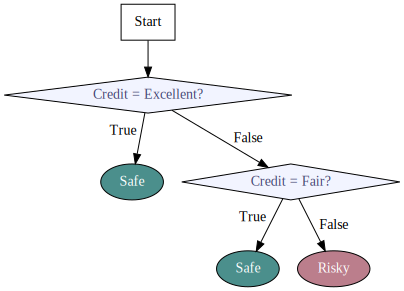

In [4]:
# TODO This doesn't work well for most of our diagrams so I'm hiding it entirely. Would love to come back and make these
# look nice.

from graphviz import Digraph

BRANCH_STYLE = {"shape": "diamond", "fillcolor": "#F2F4FF", "fontcolor": "#474973", "style": "filled"}
SAFE_STYLE = {"label": "Safe", "shape": "oval", "fillcolor": "#4B8F8C", "fontcolor": "#FFFFFF", "style": "filled"}
RISKY_STYLE = {"label": "Risky", "shape": "oval", "fillcolor": "#BB7E8C", "fontcolor": "#FFFFFF", "style": "filled"}

SAFE_FONT = "#6E8031"
RISKY_FONT = "#963334"

def font_color(text, color):
  return f'<FONT COLOR="{color}">{text}</FONT>'

# Create Digraph object
dot = Digraph()

# Make nodes and edges
dot.node("Start", shape="box")

dot.node("credit1", label="Credit = Excellent?",  **BRANCH_STYLE)
dot.node("safe1", **SAFE_STYLE)
dot.node("credit2", label="Credit = Fair?",  **BRANCH_STYLE)
dot.node("safe2", **SAFE_STYLE)
dot.node("risky1", **RISKY_STYLE)

dot.edge("Start", "credit1")
dot.edge("credit1", "safe1", xlabel="True")
dot.edge("credit1", "credit2", label="False")
dot.edge("credit2", "safe2", xlabel="True")
dot.edge("credit2", "risky1", label="False")

dot

This also aligns with how many models deal with categorical features using a *one-hot encoding* that we will discuss in more detail in a later chapter.

### Numeric Features

Dealing with numeric features requires a little bit of extra work for our decision tree model. We can't have a branch for every value of a numeric feature, since there could be an infinite number of possible values in a feature such as income (if numeric). So instead of having many splits per branch, we will need to also adapt to binary splits for numeric features as well.

```{figure} tree_split_income.png
---
alt: A decision stump split on income (numeric) with values less than $60k going left and values greater than or equal to $60k going right.
width: 75%
align: center
---
A numeric split on income being more/less than $60k
```

```{margin}
{{ref_fairness}}\. This is similar to the threshold algorithm we discussed in {doc}`../bias_fairness/index` when discussing the threshold classifier for SAT score.
```

The natural problem that comes up when we try to split this way is: how do we choose the optimal split point? In the example above, we arbitrarily chose $60k. But in general, how would we go about choose the best split? Just like we chose the best feature to split on that minimizes classification error, we also can imagine a similar algorithm that tries every possible threshold for a numeric feature to determine the best threshold. To efficiently implement this algorithm, we start by sorting the data based on the numeric feature of interest (income), and then trying every threshold to split the data into left/right groups. Our goal is to find an optimal threshold $t^*$ that minimizes the classification error if we predict the majority class for each subsection<sup>{{ref_fairness}}</sup>.

```{figure} threshold.png
---
alt: Sorting all of the examples by income and choosing some optimal split t*
width: 100%
align: center
---
Goal: Find some optimal threshold $t^*$ to divide the points by income
```

Clearly one problem with this algorithm, as described, is it's not obvious which thresholds $t$ we should try as candidates. Since the numeric feature can be a real number, there are technically an infinite number of possible thresholds to consider, which would not be very practical. However, we can make this problem tractable with one key observation: The classification error doesn't change for any of the thresholds that are between two points. Consider two adjacent examples $v_a$ and $v_b$. Any threshold $v_a \leq t \leq v_b$ will make the same predictions, therefore will have the  same classification error. So we don't really need to try every possible threshold, but just each distinct threshold between pairs of adjacent points.

```{figure} finite_thresholds.png
---
alt: Finite many thresholds that make distinct predictions between points
width: 75%
align: center
---
Finite many thresholds that make distinct predictions between points
```

It's arbitrary how we choose the exact number between two points, but taking the average $\frac{v_a + v_b}{2}$ is a common default. This now leads us to a special case of our {prf:ref}`split_node` algorithm when we run into a numeric feature $h_j(x)$ that we are considering as a split.

```{prf:algorithm} Special Case: Split Node on Numeric Feature
:label: numeric_split_node

$Split(M)$ - Numeric case

1. Sort the values of a numeric feature $h_j(x)$. Let $[v_1, v_2, ..., v_n]$ denote the sorted values.
2. for $i \in [1, ..., n - 1]$
    1. Compute split point $t_i = \frac{v_i + v_{i+1}}{2}$
    2. Compute classification error for threshold split $h_j(x) \geq t_i$
3. Return $t^*$ with minimum classification error
```

And with that, we now have a full algorithm to learn a tree from decision trees that can handle categorical or numeric features!

We now move to discuss thinking about what trees are learning at a high level, and some practicalities for training trees.

## Decision Boundaries

```{margin}
{{ref_sklearn}}\. Note that `scikit-learn` shows information at every node in the tree, branch and leaf, including how many datapoints ended up at that node. They also write down the majority class at the branch nodes even though we usually only ask for predictions at the leaf nodes. To distinguish between a branch and a leaf in `scikit-learns` display, look for a feature split at the top or the fact that leaf nodes have no children.
```

Just like our other classification methods, it helps to understand what decision trees are learning by inspecting the decision boundaries. Let's consider a small, [synthetic dataset](./synthetic.csv), for our investigation. The following code cell shows a decision stump (tree of heigh 1) trained on this dataset. It displays the tree as well as the decision boundary for that learned tree<sup>{{ref_sklearn}}</sup>.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import plot_tree

X_LIM = (0, 10)
Y_LIM = (0, 9)

def animl_plot_tree(data, tree, tree_title, figsize, **kwargs):
    fig = plt.figure(figsize=figsize)

    gs =  GridSpec(2, 2, **kwargs)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    # First plot the tree
    plot_tree(tree,
              feature_names=["feature1", "feature2"],
              class_names=["negative", "positive"],
              filled=True, impurity=False,
              ax=ax1)
    ax1.set_title(tree_title)

    # Then plot the data and boundary
    def data_scatter(ax):
        pos_data = data[data["label"] == "positive"]
        neg_data = data[data["label"] == "negative"]
        ax.scatter(x=pos_data["feature1"], y=pos_data["feature2"],
                   c="blue", marker="+", s=100)
        ax.scatter(x=neg_data["feature1"], y=neg_data["feature2"],
                   c="orange", marker="x", s=100)
        ax.set_xlabel("feature1")
        ax.set_ylabel("feature2")
        ax.set_xlim(X_LIM)
        ax.set_ylim(Y_LIM)

    # Plot data
    data_scatter(ax2)
    ax2.set_title("Synthetic Data")

    # Plot boundary
    DecisionBoundaryDisplay.from_estimator(
        tree, data[["feature1", "feature2"]], response_method="predict",
        xlabel="feature1", ylabel="feature2",
        alpha=0.1, colors=["orange", "black", "blue", "black"],
        ax=ax3)
    data_scatter(ax3)

    preds = tree.predict(data[["feature1", "feature2"]])
    accuracy = accuracy_score(data["label"], preds)

    ax3.set_title(f"Decision Boundary (Acc: {accuracy:.2f})")

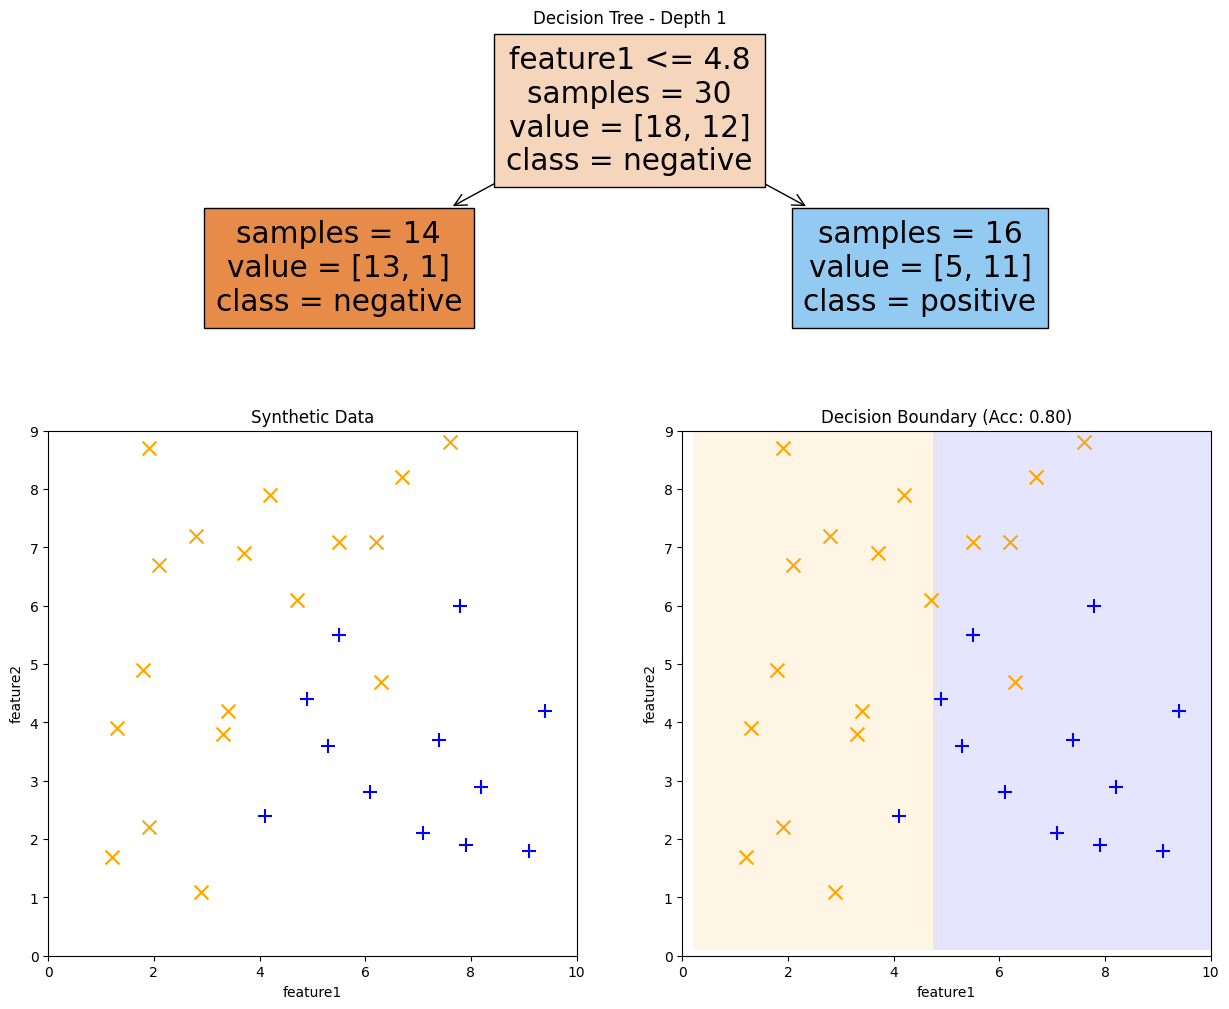

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("synthetic.csv")

tree = DecisionTreeClassifier(max_depth=1)
tree.fit(data[["feature1", "feature2"]], data["label"])

animl_plot_tree(data, tree, "Decision Tree - Depth 1",
                figsize=(15, 12), height_ratios=[4.5, 7.5])

So with a single decision stump, it's not too surprising that the decision boundary is not too complex. The learning algorithm tried every possible split for `feature1` and every possible split for `feature2`, and found the split above to minimize the classification error.

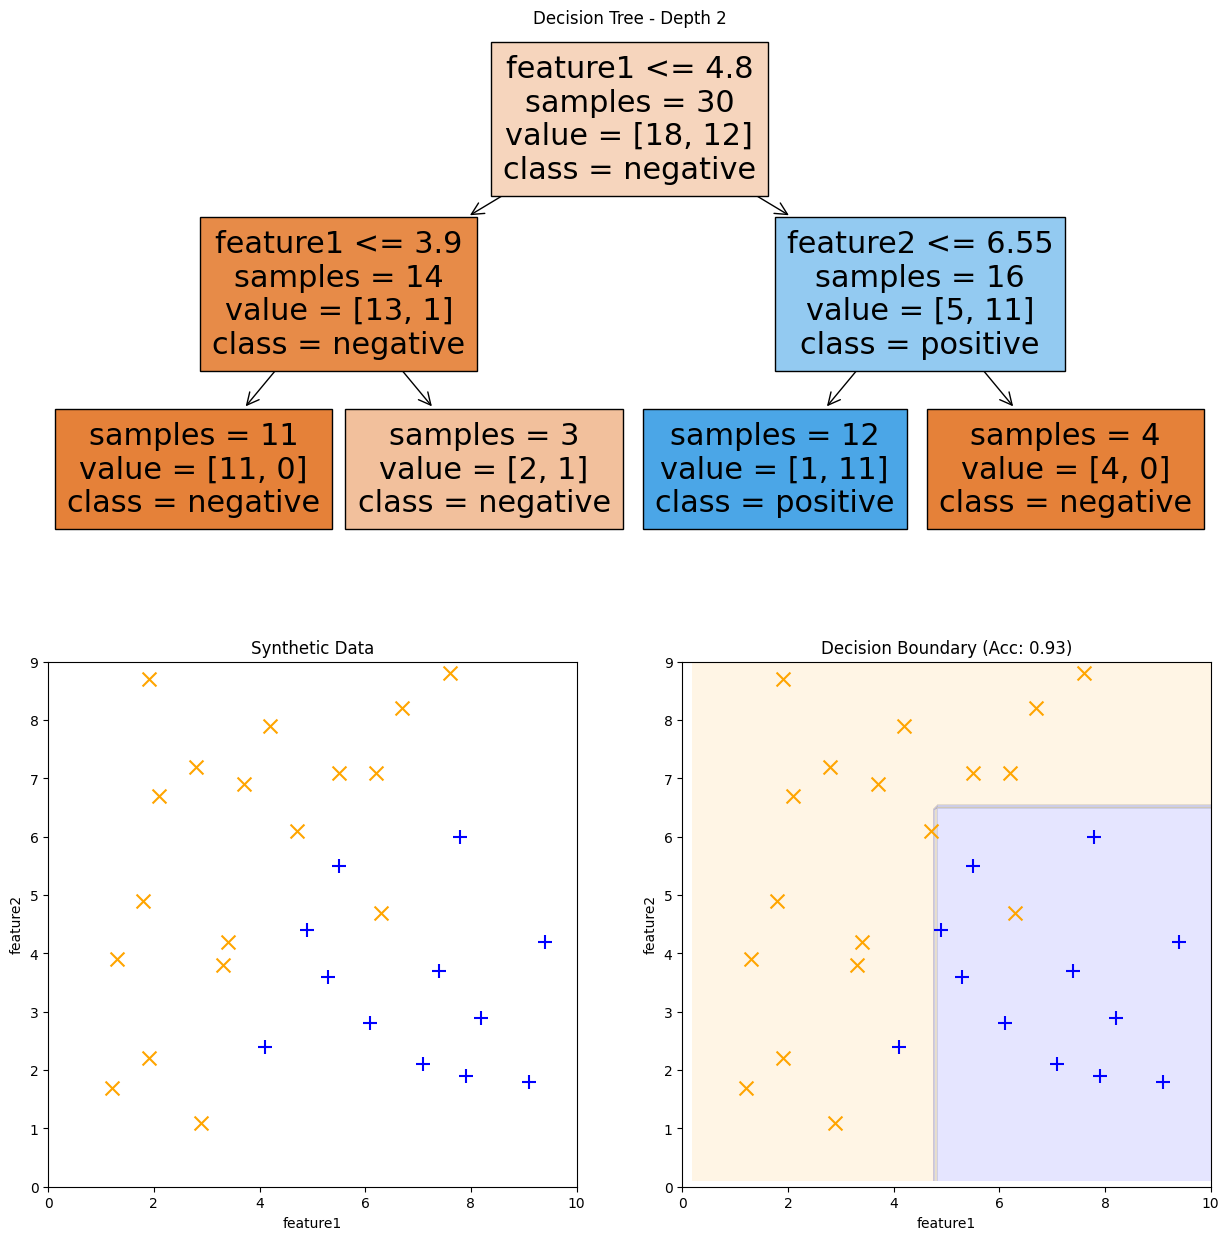

In [7]:
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(data[["feature1", "feature2"]], data["label"])

animl_plot_tree(data, tree, "Decision Tree - Depth 2",
                figsize=(15, 15))

By allowing multiple splits instead of just one, we can learn more complex decision boundaries. Note that each branch node is a simple less than / greater than split. So the overall tree is learning decision boundaries in the form of **axis-aligned rectangles**.

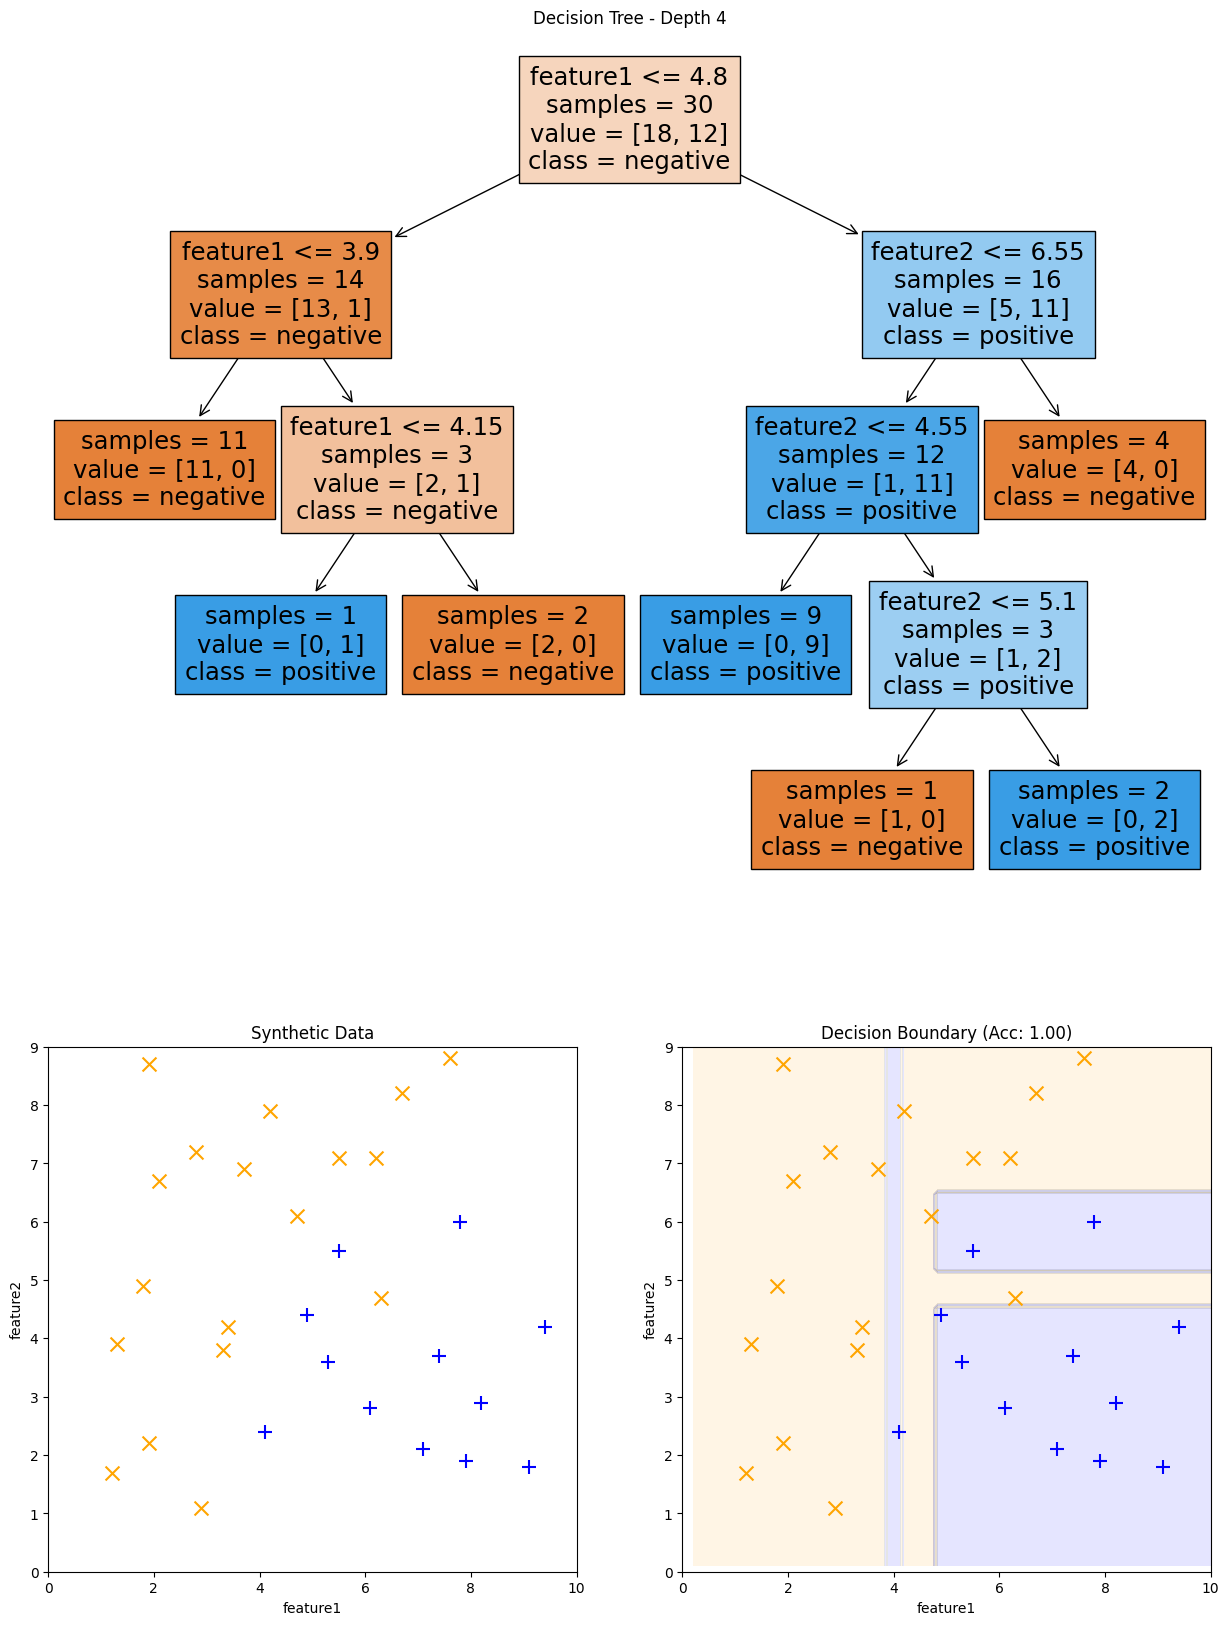

In [8]:
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(data[["feature1", "feature2"]], data["label"])

animl_plot_tree(data, tree, "Decision Tree - Depth 4",
                figsize=(15, 20), height_ratios=[12.5, 7.5])

Note that as the tree depth increases, the decision boundaries get more complex. They are still axis-align rectangles, but it can learn more and more fine-grained boundaries with a higher depth. With the complexity of this made up dataset, it turns out that 4 is the most complex depth possible and increasing the depth leads to the same model due to the greedy nature of the decision tree splits and it runs out of further splits to improve the model.

As you can probably guess from the progression we saw above, it seems to be the case that the taller a tree gets, it seems to make the model more complex which will make it more prone to overfit the data.

## Trees and Overfitting

In practice, decision trees are very prone to overfitting unless you are careful to control their model complexities. If you look back to the first code cell we showed to train a decision tree, you can see without specifying anything, it was able to get a training accuracy of 99% and only a test accuracy of 84%. That is a pretty good sign that our model is overfit. Everything we've talked about with high complexity models (likely to overfit, high variance, low bias, sensitive to changes in the training data) apply here as well.

You might have noticed in the examples in the last section, that one way to control for overfitting is to explicitly limit the depth of the tree. This is a natural and intuitive way to control for overfitting as you can see the effect of the hyperparameter on the learned model be shorter/taller. If you set this hyperparameter to be large, the model will be more complex, and if is small, the model will be more simple.

 This is not the only way to control complexity in trees though, here are some other popular hyperparameters to control complexity:

* Stop splitting when there are too few data points to split on (e.g., 10 points). The idea being that if we aren't determining a split based on a lot of data points, such as when we are deciding earlier splits at the root, then those splits are much more likely to be just noise. A larger value for the minimum number of data points required to split, make the resulting model more simple.
* Stop splitting if the split doesn't significantly decrease the classification error. The idea here is that if the split only marginally improves the model (e.g., 0.5% decrease in error), that gain may not be worth the cost of having a more complex model with the additional split. A larger value for the decrease in error required for a split will make the model simpler.

There are technically other methods (such as pruning back fully grown trees), but these three comprise some of the most commonly used ones.

How do you pick which hyperparameters to consider and which values to try out for each one? Just like every other model, trial and error! You'll need to use cross validation or a validation set to find the best possible hyperparameters. Recall that you need to try all combinations of hyperparameters you are considering to find the best ones!

## In Practice

Trees are a great model to consider, especially in circumstances when you care about *interpretable predictions*. Due to the structure of the tree being a sequence of questions until you reach an answer, it is often easy for non-machine learning experts to understand why a particular outcome was chosen.

Trees are not the perfect model though, as we discussed they are prone to overfitting without careful hyperparameter tuning. Additionally, they tend to not be the most performant models in terms of training or accuracy, but they are often used because of their interpretability.

There are a few other minor details we want to mention about decision trees before we conclude:

### Learning Tasks

While we have talked in detail about how to use trees for binary classification, they can actually work well in other contexts too:

* Trees can naturally handle multi-class classification problems as well. Each leaf node just predicts which class is most represented in the leaf node. In this case, it would technically be more appropriate to say the leaf nodes select the "plurality class", but almost everyone just says "majority class".
* Trees can also be used for regression tasks! Instead of predicting a class in the leaf nodes, you commonly predict a number such as the average label or median label. So we still have model predictions in the form of axis-aligned rectangles, but instead of predicting a class in each rectangle, the model will predict a constant numeric value. Naturally we would also change the quality metric for determining the best split to be something like mean squared error.

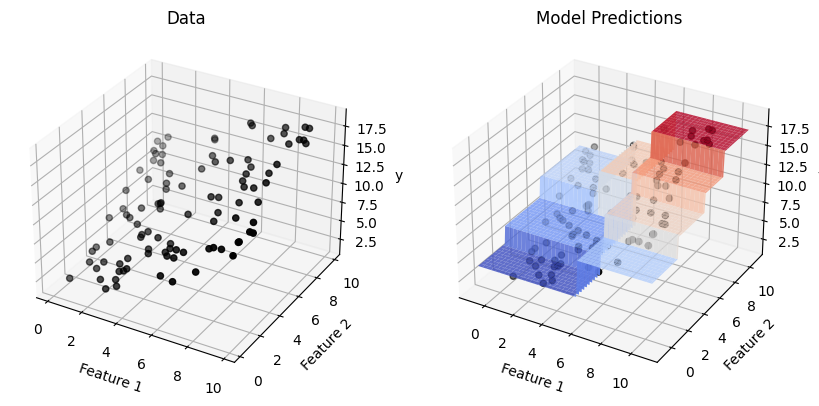

In [9]:
# This code was authored by ChatGPT and edited by Hunter
# Prompt:
# Consider a decision tree model for a regression task. Write code to train an example
# tree on a dataset with two input features and the predictions it makes in a plot.
# The plot should have two sets of axes. The axes on the left should just show the data,
# and the one on the right should show the predictions. Both axes should be 3D plots.

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.tree import DecisionTreeRegressor

# Generate some random data
np.random.seed(42)
X = np.random.rand(100, 2) * 10
y = X[:, 0] + X[:, 1] + np.random.normal(scale=0.5, size=100)

# Train a decision tree model
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

# Create a grid of points to visualize the predictions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the data and the predictions
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], y, c='black', marker='o')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('y')
ax1.set_title('Data')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
ax2.scatter(X[:, 0], X[:, 1], y, c='black', marker='o')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('y')
_ = ax2.set_title('Model Predictions')

### Quality Metrics

While intuitively finding the tree splits that minimize classification error to determine which splits to choose, we actually tend to not use that quality metric in practice. The reason being, while classification error is a good ideal to minimize, it doesn't quite capture everything we might hope to capture in a quality metric.

For example, consider an example loan dataset with 90 Safe applicants and 10 Risky ones. Consider the following two splits on made up features $F$ and $F'$.

* Split on feature $F$.
  * Left Branch: 70 Safe examples, 10 Risky examples
  * Right Branch: 20 Safe examples, 0 Risky examples
* Split on feature $F'$
  * Left Branch: 40 Safe examples, 5 Risky examples
  * Right Branch: 50 Safe examples, 5 Risky Examples

Both of these potential splits have the same accuracy of 90%. But doesn't it feel like the split on $F$ is better than the split on $F'$ since it was able to perfectly classify the examples in the right branch? Intuitively we don't want to just minimize error, but also want to reward splits that provide a lot of information by making the data in its children more pure (same label).

In practice, instead of minimizing classification error directly, we use other measurements to capture this notion of rewarding purer splits. Common metrics include **Gini Impurity** or **Information Gain**. The formulas for these metrics are outside the scope of our book, but we wanted to mention they are commonly used. The intuition for these metrics are precisely to make the split of $F$ look better than $F'$ because $F$ resulted in a purer split.

### Probability Predictions

Finally, Decision Trees can also be used in classification to make probability predictions. Recall from Logistic Regression, that we generally like the ability for the model to not only predict a class, but how likely it thinks the example is that class with a probability output. This can be done by predicting the fraction of examples in a leaf node that belong to a particular class.

For example, if you consider the tree in {numref}`example_decision_tree_1`, it would make the following probability predictions:

* The left leaf node would predict negative with probability $P(\hat{y} = =1|x) = \frac{13}{13 + 1} \approx 0.93$.
* The right leaf node would predict positive with probability $P(\hat{y} = +1|x) = \frac{11}{5 + 11} \approx 0.69$.

The probability predictions are constant across each axis-aligned rectangle since the same leaf node makes the predictions across that entire region. `scikit-learn` shows this probability predictions in each of {numref}`example_decision_tree_1`, {numref}`example_decision_tree_2`, {numref}`example_decision_tree_4` in the shade of blue/orange.

## Recap

In this chapter, we introduced the concept of decision trees and how to train them. You can use the content in this chapter to practice the following skills:

* Define what a decision tree classifier is.
* Interpret the output of a decision tree classifier.
* Assess the use of a decision tree classifier for a modeling task.
* Describe the decision tree learning algorithm and its limitations.
* Describe why a decision tree can overfit, and how various hyperparameters can prevent that.